In [1]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import cv2
from tqdm import notebook
import sys

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
import keras.backend as K
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet169

In [2]:
print(tf.__version__)
print(keras.__version__)
print(sys.version)

2.3.0
2.4.0
3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]


In [3]:
src = '../input/nyudepth-data-set-reduced-image-size/NYU-D.npz'

In [4]:
data = np.load(src)

In [5]:
Images = data['Images']
temp_depths = data['Depths']

Images = np.transpose(Images,(3,0,1,2))

Depths = []
for i in range(temp_depths.shape[-1]):
    Depths.append(temp_depths[:,:,i]/temp_depths[:,:,i].max())
    
    
Images = Images/255.
    
Depths = np.array(Depths)
Depths = Depths.reshape((Depths.shape[0], Depths.shape[1], Depths.shape[2], 1))

print(Images.shape, Depths.shape)
del data

(2284, 120, 160, 3) (2284, 120, 160, 1)


Training Data used is from NYU Depth V1 dataset (https://cs.nyu.edu/~silberman/datasets/nyu_depth_v1.html), however, the images were resized due to hardware limitations.

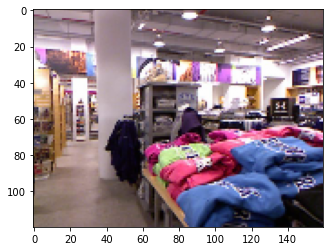

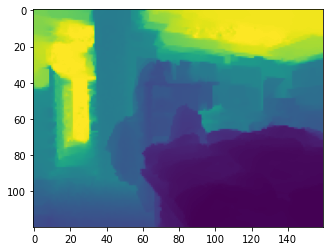

In [6]:
ind = random.randint(0, Images.shape[0])

plt.figure()
plt.imshow(Images[ind,:,:,:])

plt.figure()
plt.imshow(Depths[ind,:,:,0])


In [7]:
image_data_gen_args = dict(
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1, 
                     horizontal_flip=True)

image_datagen = ImageDataGenerator(**image_data_gen_args)
depth_datagen = ImageDataGenerator(**image_data_gen_args)

val_image_datagen = ImageDataGenerator(**image_data_gen_args)
val_depth_datagen = ImageDataGenerator(**image_data_gen_args)


seed = 1
image_datagen.fit(Images[:-250,:,:,:], augment=True, seed=seed)
depth_datagen.fit(Depths[:-250,:,:,:], augment=True, seed=seed)

val_image_datagen.fit(Images[-250:,:,:,:], augment=True, seed=seed)
val_depth_datagen.fit(Depths[-250:,:,:,:], augment=True, seed=seed)

train_image_generator = image_datagen.flow(Images[:-250,:,:,:], batch_size=8, seed=seed)
train_depth_generator = depth_datagen.flow(Depths[:-250,:,:,:], batch_size=8, seed=seed)

validate_image_generator = val_image_datagen.flow(Images[-250:,:,:,:], seed=seed)
validate_depth_generator = val_depth_datagen.flow(Depths[-250:,:,:,:], seed=seed)


train_generator = zip(train_image_generator, train_depth_generator)

validation_generator = zip(validate_image_generator, validate_depth_generator)



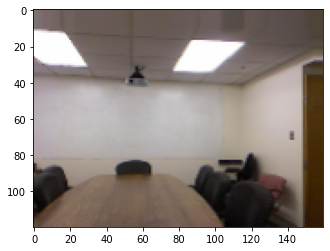

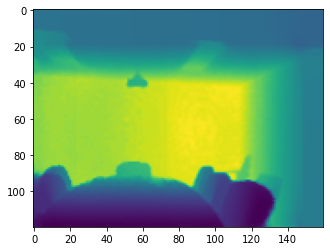

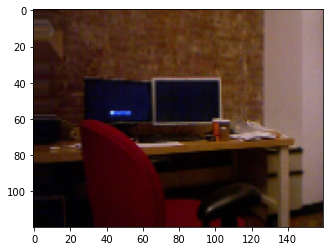

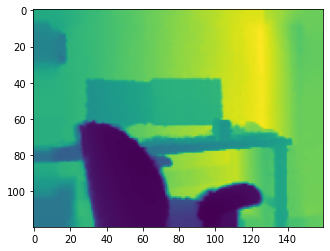

In [8]:
idx = random.randint(0,7)

k = next(train_image_generator)
plt.figure()
plt.imshow(k[idx])

k = next(train_depth_generator)
plt.figure()
plt.imshow(np.squeeze(k[idx]))

k = next(validate_image_generator)
plt.figure()
plt.imshow(k[idx])

k = next(validate_depth_generator)
plt.figure()
plt.imshow(np.squeeze(k[idx]))

In [9]:
img_ht = 120
img_wd = 160

In [10]:
base_model = DenseNet169(
                include_top=False,
                weights='imagenet',
                input_shape=(img_ht,img_wd,3))

51879936/51877672 [==============================] - 1s 0us/step


In [11]:
base_model.trainable=False

In [12]:
''' NORMAL U-NET DECODER '''
main_input = Input(shape=(120,160,3))

dnet = base_model(main_input, training = False)

conv1 = Conv2D(1280, (3,3), padding='same')(base_model.output)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)

conv1 = Conv2D(1280, (3,3), padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)

up1 = Conv2DTranspose(1280, kernel_size=(2,2), strides = 2, activation='relu')(conv1)
up1 = ZeroPadding2D(((0,1),(0,0)))(up1)

x = base_model.layers[366].output

concat1 = concatenate([up1, x])

conv2 = Conv2D(512, (3,3), padding='same')(concat1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)

conv2 = Conv2D(512, (3,3), padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)

up2 = Conv2DTranspose(512, kernel_size=(2,2), strides = 2, activation='relu')(conv2)
up2 = ZeroPadding2D(((0,1),(0,0)))(up2)

x = base_model.layers[138].output

concat2 = concatenate([up2, x])

conv3 = Conv2D(128, (3,3), padding='same')(concat2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)

conv3 = Conv2D(128, (3,3), padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)

up3 = Conv2DTranspose(128, kernel_size=(2,2), strides = 2, activation='relu')(conv3)

x = base_model.layers[46].output

concat3 = concatenate([up3, x])

conv4 = Conv2D(64, (3,3), padding='same')(concat3)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)

conv4 = Conv2D(64, (3,3), padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)

up4 = Conv2DTranspose(64, kernel_size=(2,2), strides = 2, activation='relu')(conv4)

x = base_model.layers[4].output

concat4 = concatenate([up4, x])

conv5 = Conv2D(32, (3,3), padding='same')(concat4)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)

conv5 = Conv2D(32, (3,3), padding='same')(conv5)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)

up5 = Conv2DTranspose(32, kernel_size=(2,2), strides = 2, activation='relu')(conv5)

x = base_model.layers[0].output

conv_ip = Conv2D(32, (3,3), padding = 'same')(x)
conv_ip = BatchNormalization()(conv_ip)
conv_ip = Activation('relu')(conv_ip)

conv_ip = Conv2D(32, (3,3), padding = 'same')(conv_ip)
conv_ip = BatchNormalization()(conv_ip)
conv_ip = Activation('relu')(conv_ip)

concat5 = concatenate([up5, conv_ip])

conv6 = Conv2D(32, (3,3), padding = 'same')(concat5)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)

conv6 = Conv2D(16, (3,3), padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)

conv6 = Conv2D(8, (1,1), padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)

depth_out = Conv2D(1, (1,1), activation='relu')(conv6)

model = Model(inputs = base_model.input, outputs = depth_out)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 126, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 60, 80, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 60, 80, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [13]:
def custom_loss(y_true, y_pred):
    
    mae = keras.losses.MeanAbsoluteError()
    mean_abs_l = mae(y_true, y_pred)
    
    dx_true, dy_true = tf.image.image_gradients(y_true)
    dx_pred, dy_pred = tf.image.image_gradients(y_pred)
    
    gradient_loss = mae(dx_true, dx_pred) + mae(dy_true, dy_pred)
    
    Lssim = (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)))*0.5
    
    return (mean_abs_l + gradient_loss + Lssim)

In [14]:
opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

In [15]:
model.compile(optimizer = opt, loss = custom_loss)

In [16]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=Images.shape[0]//8, 
                              epochs=30, 
                              validation_data = validation_generator,
                              validation_steps = 8,
                              use_multiprocessing = True)

Epoch 1/30
285/285 [==============================] - 36s 125ms/step - loss: 0.6943 - val_loss: 0.4287
Epoch 2/30
285/285 [==============================] - 31s 110ms/step - loss: 0.4440 - val_loss: 0.3384
Epoch 3/30
285/285 [==============================] - 31s 110ms/step - loss: 0.4080 - val_loss: 0.3080
Epoch 4/30
285/285 [==============================] - 31s 110ms/step - loss: 0.3623 - val_loss: 0.3029
Epoch 5/30
285/285 [==============================] - 31s 108ms/step - loss: 0.2953 - val_loss: 0.3050
Epoch 6/30
285/285 [==============================] - 32s 114ms/step - loss: 0.2626 - val_loss: 0.2809
Epoch 7/30
285/285 [==============================] - 31s 109ms/step - loss: 0.2424 - val_loss: 0.2770
Epoch 8/30
285/285 [==============================] - 32s 112ms/step - loss: 0.2281 - val_loss: 0.2732
Epoch 9/30
285/285 [==============================] - 31s 108ms/step - loss: 0.2186 - val_loss: 0.2747
Epoch 10/30
285/285 [==============================] - 32s 111ms/step - l

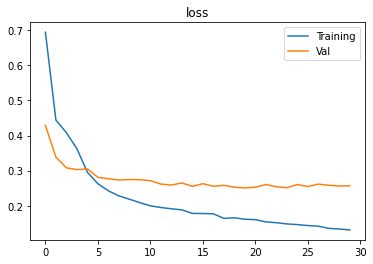

In [17]:
plt.figure()
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Val')
plt.title('loss')
plt.legend()

It is evident that the loss was still reducing, however the training had to be terminated due to hardware limitations.

986


Text(0.5, 1.0, 'Prediction')

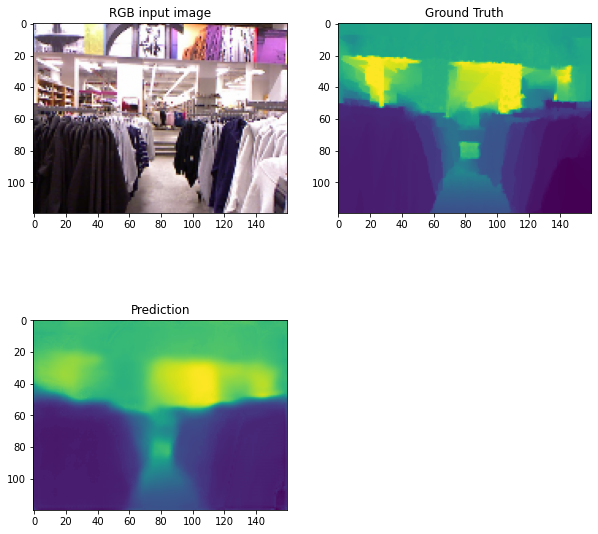

In [18]:
ind = random.randint(0, Images.shape[0])
print(ind)

img = Images[ind,:,:,:]
ground_truth =Depths[ind,:,:]

preds = model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
prediction = preds[0,:,:]

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)


ax1.imshow(img)
ax1.set_title('RGB input image')

ax2.imshow(ground_truth[:,:,0])
ax2.set_title('Ground Truth')

ax3.imshow(prediction[:,:,0])
ax3.set_title('Prediction')

In [19]:
model.save_weights('ModelWeights.hdf5')

In [20]:
## serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)